In [157]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from tabulate import tabulate

# Load data
path_to_data = ''
zenodo_data = '../data/'

# example here: LDO, same for LPO and LCO run
lpo_id = 'to_the_universe_new/'
lco_id = 'to_the_stars/'
ldo_id = 'ldo_results/'

# Load evaluation results
evaluation_results_lpo = pd.read_csv(f'{path_to_data}{lpo_id}evaluation_results.csv')
evaluation_results_lco = pd.read_csv(f'{path_to_data}{lco_id}evaluation_results.csv')
evaluation_results_ldo = pd.read_csv(f'{path_to_data}{ldo_id}evaluation_results.csv')
evaluation_results = pd.concat([evaluation_results_lpo, evaluation_results_lco, evaluation_results_ldo])

true_vs_pred_lpo = pd.read_csv(f'{path_to_data}{lpo_id}true_vs_pred.csv')
true_vs_pred_lco = pd.read_csv(f'{path_to_data}{lco_id}true_vs_pred.csv')
true_vs_pred_ldo = pd.read_csv(f'{path_to_data}{ldo_id}true_vs_pred.csv')
true_vs_pred = pd.concat([true_vs_pred_lpo, true_vs_pred_lco, true_vs_pred_ldo])

# ========== Table 1 / S7 ==========
# All results (mean±std per metric)
all_results = evaluation_results[evaluation_results['rand_setting'] == "predictions"]
all_results = all_results.melt(id_vars=["algorithm", "LPO_LCO_LDO", "CV_split"],
                               value_vars=["MSE", "R^2", "Pearson", "R^2: normalized", "Pearson: normalized"],
                               var_name="metric")

all_results['mean'] = all_results.groupby(['algorithm', 'LPO_LCO_LDO', 'metric'])['value'].transform('mean').round(2)
all_results['std'] = all_results.groupby(['algorithm', 'LPO_LCO_LDO', 'metric'])['value'].transform('std').round(2)
all_results['value'] = all_results['mean'].astype(str) + "±" + all_results['std'].astype(str)

all_results = all_results.drop(columns=["CV_split", "mean", "std"])
all_results = all_results.drop_duplicates()
all_results = all_results.pivot(index=["algorithm", "LPO_LCO_LDO"], columns="metric", values="value").reset_index()

# Pearson per drug and cell line
tp = true_vs_pred[true_vs_pred['rand_setting'] == "predictions"]

def calculate_pearson(group):
    if len(group) > 1:
        return pearsonr(group['y_true'], group['y_pred'])[0]
    return np.nan

pearson_per_drug = tp.groupby(['algorithm', 'LPO_LCO_LDO', 'drug']).apply(calculate_pearson).reset_index(name='Pearson')
pearson_per_cl = tp.groupby(['algorithm', 'LPO_LCO_LDO', 'cell_line']).apply(calculate_pearson).reset_index(name='Pearson')

agg_drug = pearson_per_drug.groupby(['algorithm', 'LPO_LCO_LDO'])['Pearson'].agg(['mean', 'std']).round(2).reset_index()
agg_drug['Pearson per drug'] = agg_drug['mean'].astype(str) + "±" + agg_drug['std'].astype(str)
agg_drug = agg_drug[['algorithm', 'LPO_LCO_LDO', 'Pearson per drug']]

agg_cl = pearson_per_cl.groupby(['algorithm', 'LPO_LCO_LDO'])['Pearson'].agg(['mean', 'std']).round(2).reset_index()
agg_cl['Pearson per cell line'] = agg_cl['mean'].astype(str) + "±" + agg_cl['std'].astype(str)
agg_cl = agg_cl[['algorithm', 'LPO_LCO_LDO', 'Pearson per cell line']]

# Merge Pearson results
all_results = pd.merge(all_results, agg_drug, on=['algorithm', 'LPO_LCO_LDO'], how='left')
all_results = pd.merge(all_results, agg_cl, on=['algorithm', 'LPO_LCO_LDO'], how='left')

# Final formatting
all_results['LPO_LCO_LDO'] = pd.Categorical(all_results['LPO_LCO_LDO'], categories=['LPO', 'LCO', 'LDO'], ordered=True)
all_results = all_results.sort_values(by=['LPO_LCO_LDO', 'MSE'])

all_results = all_results.rename(columns={
    "algorithm": "Model",
    "R^2": "$R^2$",
    "R^2: normalized": "$R^2$: normalized",
    "Pearson": "Pearson",
    "Pearson: normalized": "Pearson: normalized"
})

# Underline baseline model
baseline = 'NaiveMeanEffectsPredictor'
cols_to_format = ['MSE', '$R^2$', '$R^2$: normalized', 'Pearson', 'Pearson: normalized', 'Pearson per drug', 'Pearson per cell line']
all_results.loc[all_results['Model'] == baseline, cols_to_format] = \
    all_results.loc[all_results['Model'] == baseline, cols_to_format].applymap(lambda x: f"\\underline{{{x}}}")

# LaTeX output
latex_table = tabulate(all_results, headers='keys', tablefmt='latex', showindex=False)
print(latex_table)

# ========== Table 2 / S4 / S5 ==========
# Cross-study results for MSE
metric_for_visualization = "MSE"
cs_results = evaluation_results.melt(id_vars=["algorithm", "LPO_LCO_LDO", "CV_split", "rand_setting"],
                                     value_vars=["MSE", "R^2", "Pearson"],
                                     var_name="metric")

cs_results['mean'] = cs_results.groupby(['algorithm', 'LPO_LCO_LDO', 'rand_setting', 'metric'])['value'].transform('mean').round(2)
cs_results['std'] = cs_results.groupby(['algorithm', 'LPO_LCO_LDO', 'rand_setting', 'metric'])['value'].transform('std').round(2)
cs_results['value'] = cs_results['mean'].astype(str) + "±" + cs_results['std'].astype(str)

cs_results = cs_results.drop(columns=["CV_split", "mean", "std"])
cs_results = cs_results.drop_duplicates()
cs_results = cs_results[cs_results['metric'] == metric_for_visualization]

cs_results = cs_results.pivot(index=["algorithm", "LPO_LCO_LDO"], columns="rand_setting", values="value").reset_index()

cs_results['LPO_LCO_LDO'] = pd.Categorical(cs_results['LPO_LCO_LDO'], categories=['LPO', 'LCO', 'LDO'], ordered=True)
cs_results = cs_results.sort_values(by=['LPO_LCO_LDO', 'algorithm'])

cs_results = cs_results.rename(columns={
    "algorithm": "Model",
    "CTRPv2": "CTRPv2",
    "cross-study-CTRPv1": "Cross-study: CTRPv1",
    "cross-study-CCLE": "Cross-study: CCLE",
    "cross-study-GDSC1": "Cross-study: GDSC1",
    "cross-study-GDSC2": "Cross-study: GDSC2"
})

# LaTeX output
latex_table_cs = tabulate(cs_results, headers='keys', tablefmt='latex', showindex=False)
print(latex_table_cs)

/var/folders/62/nxnmxsmj1q15tr6b3ywgks88r_qppl/T/ipykernel_95278/3309498108.py:23: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  true_vs_pred_lpo = pd.read_csv(f'{path_to_data}{lpo_id}true_vs_pred.csv')
/var/folders/62/nxnmxsmj1q15tr6b3ywgks88r_qppl/T/ipykernel_95278/3309498108.py:24: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  true_vs_pred_lco = pd.read_csv(f'{path_to_data}{lco_id}true_vs_pred.csv')
/var/folders/62/nxnmxsmj1q15tr6b3ywgks88r_qppl/T/ipykernel_95278/3309498108.py:48: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return pearsonr(group['y_true'], group['y_pred'])[0]
/var/folders/62/nxnmxsmj1q15tr6b3ywgks88r_qppl/T/ipykernel_95278/3309498108.py:51: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will b

\begin{tabular}{lllllllll}
\hline
 Model                          & LPO\_LCO\_LDO   & MSE                   & Pearson               & Pearson: normalized   & \$R\^{}2\$                 & \$R\^{}2\$: normalized      & Pearson per drug       & Pearson per cell line   \\
\hline
 DIPK                           & LPO           & 1.15±0.04             & 0.91±0.0              & 0.58±0.03             & 0.82±0.01             & 0.32±0.03              & 0.53±0.27              & 0.89±0.08               \\
 SimpleNeuralNetwork            & LPO           & 1.4±0.06              & 0.88±0.01             & 0.43±0.03             & 0.78±0.01             & 0.17±0.03              & 0.44±0.25              & 0.86±0.07               \\
 RandomForest                   & LPO           & 1.58±0.04             & 0.87±0.0              & 0.3±0.01              & 0.75±0.01             & 0.06±0.01              & 0.4±0.26               & 0.86±0.08               \\
 SingleDrugProteomicsElasticNet & LPO           & 1.68±

/var/folders/62/nxnmxsmj1q15tr6b3ywgks88r_qppl/T/ipykernel_95278/3309498108.py:52: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pearson_per_cl = tp.groupby(['algorithm', 'LPO_LCO_LDO', 'cell_line']).apply(calculate_pearson).reset_index(name='Pearson')
/var/folders/62/nxnmxsmj1q15tr6b3ywgks88r_qppl/T/ipykernel_95278/3309498108.py:82: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  all_results.loc[all_results['Model'] == baseline, cols_to_format].applymap(lambda x: f"\\underline{{{x}}}")


/var/folders/62/nxnmxsmj1q15tr6b3ywgks88r_qppl/T/ipykernel_95278/2459636599.py:47: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax1 = sns.violinplot(


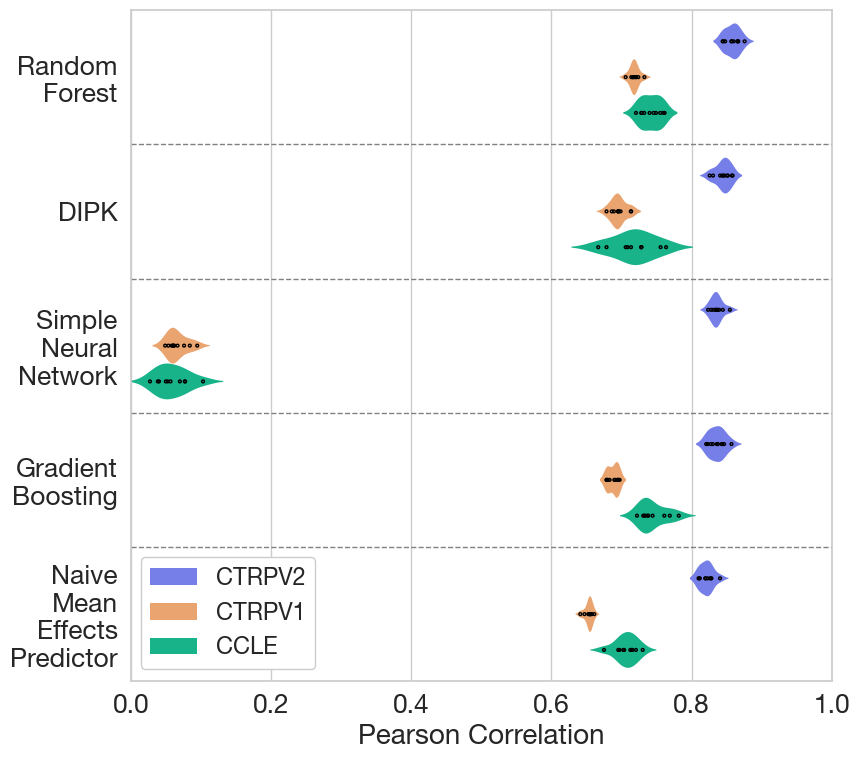

In [158]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.collections import PathCollection

# Custom Plotly colors
custom_colors = [
    '#636EFA', '#FFA15A', '#00CC96'
]

# Define font size settings
size = 10

def set_global_fontsize(increment=2, base=12):
    plt.rcParams.update({
        'font.size': base + increment,
        'axes.titlesize': base + increment + 1,
        'axes.labelsize': base + increment,
        'xtick.labelsize': base + increment - 1,
        'ytick.labelsize': base + increment - 1,
        'legend.fontsize': base + increment - 3,
        'font.family': 'Helvetica Neue'  # Set font to Helvetica Neue
    })

set_global_fontsize(8)

# Shared settings
models_to_keep = {"DIPK", "SimpleNeuralNetwork", "RandomForest", "NaiveMeanEffectsPredictor", "GradientBoosting"}
model_order = ["RandomForest", "DIPK", "SimpleNeuralNetwork", "NaiveMeanEffectsPredictor", "GradientBoosting"]
datasets_to_keep = ["CTRPV2", "CTRPV1", "CCLE"]

# ======================== Transposed Pearson Violin Plot ========================
metric = "Pearson"  # Updated to use "Pearson" metric
df = evaluation_results[
    (evaluation_results[metric].notnull()) & (evaluation_results["LPO_LCO_LDO"] == "LCO")
].copy()
df['rand_setting'] = df['rand_setting'].str.replace("cross-study-", "", regex=False).str.upper()
df['rand_setting'] = df['rand_setting'].replace({"PREDICTIONS": "CTRPV2"})
df = df[df['rand_setting'].isin(datasets_to_keep)]
df = df[df['algorithm'].isin(models_to_keep)]
df['algorithm'] = df['algorithm'].replace({"SimpleNeuralNetwork": "Simple\nNeural\nNetwork", "NaiveMeanEffectsPredictor": "Naive\nMean\nEffects\nPredictor", "GradientBoosting": "Gradient\nBoosting", "DIPK": "DIPK", "RandomForest": "Random\nForest"})
df['algorithm'] = pd.Categorical(df['algorithm'], categories=["Random\nForest", "DIPK", "Simple\nNeural\nNetwork",  "Gradient\nBoosting", "Naive\nMean\nEffects\nPredictor",], ordered=True)

df['rand_setting'] = pd.Categorical(df['rand_setting'], categories=datasets_to_keep, ordered=True)

plt.figure(figsize=(9, 8))  # Adjust size for better vertical layout
ax1 = sns.violinplot(
    data=df,
    y='algorithm',  # flipped axes
    x=metric,       # flipped axes
    hue='rand_setting',
    palette=custom_colors[:len(datasets_to_keep)],
    dodge=True,
    inner="point",
    scale="width",
    linewidth=1,
    edgecolor='none'
)

# Set the border color for inner points
for i, artist in enumerate(ax1.collections):
    if isinstance(artist, PathCollection):
        artist.set_edgecolor("black")

# Add horizontal dotted lines between models
for i in range(len(model_order) - 1):
    plt.axhline(y=i + 0.5, color='grey', linestyle='--', linewidth=1)

# Adjust legend position for vertical layout
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles=handles, labels=labels, loc='lower right', bbox_to_anchor=(0.28, 0.001), framealpha=1)

plt.ylabel(None)
plt.xlim(0, 1)
plt.xlabel(f"{metric} Correlation")

plt.tight_layout()
plt.savefig("figures/cross_study_violins_vertical.pdf", format="pdf", bbox_inches='tight', dpi=300)
plt.show()


/var/folders/62/nxnmxsmj1q15tr6b3ywgks88r_qppl/T/ipykernel_95278/1601274047.py:23: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax1 = sns.violinplot(
/var/folders/62/nxnmxsmj1q15tr6b3ywgks88r_qppl/T/ipykernel_95278/1601274047.py:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  baseline_stats = df[df['algorithm'] == baseline_model].groupby('rand_setting')[metric].agg(['mean', 'std'])


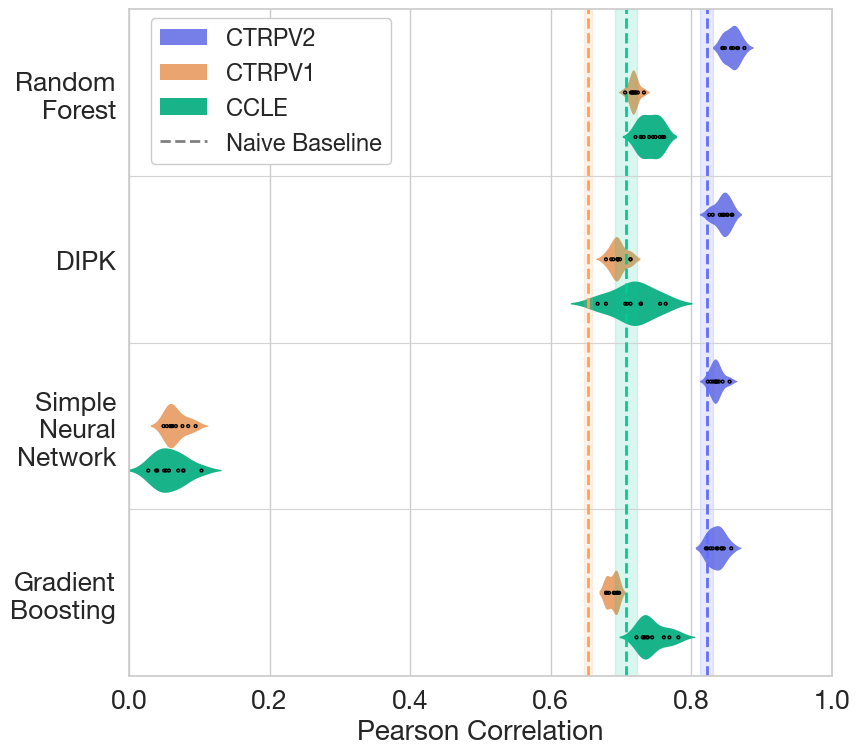

In [159]:
plt.figure(figsize=(9, 8))

# Filter out the baseline model from the violin plot data
baseline_model = "Naive\nMean\nEffects\nPredictor"
violin_df = df[df['algorithm'] != baseline_model].copy()

# Update algorithm category order without baseline model
visible_algorithms = [alg for alg in model_order if alg != "NaiveMeanEffectsPredictor"]
pretty_alg_names = {
    "SimpleNeuralNetwork": "Simple\nNeural\nNetwork",
    "NaiveMeanEffectsPredictor": "Naive\nMean\nEffects\nPredictor",
    "GradientBoosting": "Gradient\nBoosting",
    "DIPK": "DIPK",
    "RandomForest": "Random\nForest"
}
violin_df['algorithm'] = violin_df['algorithm'].cat.remove_categories([baseline_model])
violin_df['algorithm'] = pd.Categorical(violin_df['algorithm'],
    categories=[pretty_alg_names[m] for m in visible_algorithms],
    ordered=True
)

# Create the violin plot
ax1 = sns.violinplot(
    data=violin_df,
    y='algorithm',
    x=metric,
    hue='rand_setting',
    palette=custom_colors[:len(datasets_to_keep)],
    dodge=True,
    inner="point",
    scale="width",
    linewidth=1,
    edgecolor='none'
)

# Set the border color for inner points
for i, artist in enumerate(ax1.collections):
    if isinstance(artist, PathCollection):
        artist.set_edgecolor("black")

# Add horizontal dotted lines between remaining models
for i in range(len(violin_df['algorithm'].cat.categories) - 1):
    plt.axhline(y=i + 0.5, color='lightgrey', linestyle='-', linewidth=.8)

# Compute baseline means and stds for each dataset
baseline_stats = df[df['algorithm'] == baseline_model].groupby('rand_setting')[metric].agg(['mean', 'std'])

# Add vertical lines and shaded std regions
for i, dataset in enumerate(datasets_to_keep):
    if dataset in baseline_stats.index:
        mean_val = baseline_stats.loc[dataset, 'mean']
        std_val = baseline_stats.loc[dataset, 'std']
        
        # Add vertical line for mean
        ax1.axvline(x=mean_val, color=custom_colors[i], linestyle='--', linewidth=2, label=f'{dataset} Baseline')
        
        # Add shaded region for ±1 std
        ax1.axvspan(mean_val - std_val, mean_val + std_val,
                    color=custom_colors[i], alpha=0.15)

# After plotting the baseline vertical lines and shaded areas:


# Get the current legend handles and labels
handles, labels = ax1.get_legend_handles_labels()

# Remove the individual baseline model entries from the legend
handles = [handle for handle, label in zip(handles, labels) if 'Baseline' not in label]
labels = [label for label in labels if 'Baseline' not in label]

# Now add a single "Naive Baseline" entry in a neutral gray color
handles.append(plt.Line2D([0], [0], color='gray', linestyle='--', linewidth=2))  # Line for baseline
labels.append('Naive Baseline')

# Create the legend with the modified handles and labels
ax1.legend(handles=handles, labels=labels, loc='lower right', bbox_to_anchor=(0.39, 0.75), framealpha=1)




plt.ylabel(None)
plt.xlim(0, 1)
plt.xlabel(f"{metric} Correlation")

plt.tight_layout()
plt.savefig("figures/cross_study_violins_vertical_baseline.pdf", format="pdf", bbox_inches='tight', dpi=300)
plt.show()


In [178]:
all_results

,Model,LPO_LCO_LDO,MSE,Pearson,Pearson: normalized,$R^2$,$R^2$: normalized,Pearson per drug,Pearson per cell line
2,DIPK,LPO,1.15±0.04,0.91±0.0,0.58±0.03,0.82±0.01,0.32±0.03,0.53±0.27,0.89±0.08
29,SimpleNeuralNetwork,LPO,1.4±0.06,0.88±0.01,0.43±0.03,0.78±0.01,0.17±0.03,0.44±0.25,0.86±0.07
24,RandomForest,LPO,1.58±0.04,0.87±0.0,0.3±0.01,0.75±0.01,0.06±0.01,0.4±0.26,0.86±0.08
31,SingleDrugProteomicsElasticNet,LPO,1.68±0.03,0.86±0.0,0.28±0.01,0.74±0.01,0.01±0.01,0.25±0.35,0.86±0.08
7,GradientBoosting,LPO,1.75±0.04,0.86±0.0,0.15±0.01,0.73±0.01,-0.03±0.01,0.42±0.24,0.84±0.08
18,NaiveMeanEffectsPredictor,LPO,\underline{1.7±0.03},\underline{0.86±0.0},\underline{0.0±0.0},\underline{0.74±0.01},\underline{-0.0±0.0},\underline{0.4±0.25},\underline{0.84±0.09}
15,NaiveDrugMeanPredictor,LPO,2.09±0.03,0.82±0.0,0.02±0.01,0.67±0.01,-0.23±0.01,-0.21±0.19,0.84±0.08
26,SRMF,LPO,2.77±0.36,0.81±0.02,0.44±0.03,0.57±0.06,-0.64±0.23,0.51±0.3,0.8±0.14
9,MultiOmicsNeuralNetwork,LPO,2.94±0.54,0.74±0.06,0.06±0.03,0.55±0.08,-0.73±0.31,0.35±0.24,0.72±0.07
4,ElasticNet,LPO,4.07±0.05,0.61±0.01,0.0±0.01,0.37±0.01,-1.41±0.04,0.43±0.24,0.57±0.09
